# MSiA 423 - Cloud Engineering for Data Science - Final Project
## Group 7: Alejandra Lelo de Larrea Ibarra, Bannasorn Paspanthong, Ruben Nakano, Samuel Swain
# Modeling

In [3]:
# Libraries 
import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import random
import math

from typing import Tuple

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [4]:
# --- Read csv file directly from the zip ---
archive = zipfile.ZipFile('../../02_Data/clean_data.zip', 'r')
files = archive.namelist()

# --- Load data sets --- 
with archive.open(files[0]) as csvfile:   
    df = pd.read_csv(csvfile)

In [5]:
# Look at the data
df.sample(10)

,book_date,airline,flight,class,departure_time,origin,duration,stops,arrival_time,destination,price
292280,21-02-2022,Vistara,UK-826,Economy,Afternoon,Chennai,31.08,1,Evening,Kolkata,19889
265172,20-02-2022,Air India,AI-543,Economy,Morning,Hyderabad,7.83,2,Evening,Kolkata,12958
181172,02-03-2022,GO FIRST,G8-7543,Economy,Afternoon,Bangalore,9.92,1,Night,Delhi,3466
275684,25-02-2022,Indigo,6E-2065,Economy,Early_Morning,Chennai,2.83,0,Morning,Delhi,7352
13867,09-03-2022,Vistara,UK-953,Business,Night,Delhi,15.58,1,Afternoon,Hyderabad,39377
164129,14-02-2022,Air India,AI-867,Economy,Night,Mumbai,26.08,1,Night,Hyderabad,7584
13757,07-03-2022,Air India,AI-624,Business,Evening,Delhi,12.25,1,Early_Morning,Hyderabad,39321
219412,22-03-2022,GO FIRST,G8-102,Economy,Afternoon,Kolkata,2.58,0,Evening,Delhi,3999
257334,19-03-2022,Indigo,6E-6433,Economy,Night,Hyderabad,9.75,1,Morning,Mumbai,5506
251597,28-03-2022,AirAsia,I5-974,Economy,Night,Hyderabad,10.67,1,Morning,Delhi,2228


In [6]:
# --- Apply transformations based on EDA ---

# Drop column book_date
df.drop(['book_date'], axis=1, inplace=True)

# Drop airlines with less than 1000 flights
df = df.groupby('airline').filter(lambda x: len(x) > 1000)

# Log price
df['price'] = np.log(df['price'])

In [7]:
# Define the categorical and numerical features
cat_features = ['airline', 'flight', 'class', 'departure_time', 'origin', 'arrival_time', 'destination', 'stops']
num_features = ['duration']

In [8]:
# Preprocess data
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

In [9]:
# Define the models
models = {
    'Linear Regression': (LinearRegression(), {}),
    'Random Forest': (RandomForestRegressor(random_state=423), {
        'model__n_estimators': [200],
        'model__max_depth': [10],
        'model__min_samples_split': [2]
    }),
    'XGBoost': (XGBRegressor(random_state=423), {
        'model__n_estimators': [200],
        'model__max_depth': [10],
        'model__learning_rate': [0.1]
    })
}

In [10]:
# Train and evaluate models with hyperparameter tuning
def train_and_evaluate(models: dict, X: pd.DataFrame, y: pd.Series) -> Tuple[dict, dict]:
    """
    This function trains and evaluates the models passed as a dictionary.

    Args:
        models (dict): Dictionary of models to train and evaluate.
        X (pandas.DataFrame): Features.
        y (pandas.Series): Target variable.

    Returns:
        results (dict): Dictionary of results.
        trained_models (dict): Dictionary of trained models.

    """
    
    # Initialize results and trained models dictionaries
    results = {}
    trained_models = {}

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=423)

    # Loop through models
    for name, (model, params) in models.items():

        # Create pipeline object
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

        # Fit the model depending on whether hyperparameter tuning is required
        if params:
            grid_search = GridSearchCV(pipeline, param_grid=params, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
        else:
            best_model = pipeline
            best_model.fit(X_train, y_train)

        # Predict on test set
        y_pred = best_model.predict(X_test)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        # Store results and trained models
        trained_models[name] = best_model
        results[name] = {'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'R2': r2}

        # Print results
        print(f'{name}:\nMSE: {mse}\nMAE: {mae}\nRMSE: {rmse}\nR2: {r2}\n')

    return results, trained_models

In [11]:
# Separate features and target
X = df.drop('price', axis=1)
y = df['price']

In [12]:
results, trained_models = train_and_evaluate(models, X, y)

Linear Regression:
MSE: 0.12012433136363178
MAE: 0.2587442934262719
RMSE: 0.3465895719199177
R2: 0.9030055535988217

Random Forest:
MSE: 0.12072991263861334
MAE: 0.25182871434209625
RMSE: 0.34746210244948056
R2: 0.9025165767208573

XGBoost:
MSE: 0.10652390875011337
MAE: 0.2364349097233906
RMSE: 0.3263800066641849
R2: 0.9139872210698938



## Check to see if Linear Regression result is correct

In [13]:
# Perform one-hot encoding
X_encoded = pd.get_dummies(X, columns=cat_features)

# Print the encoded dataframe
print(X_encoded)

        duration  airline_Air India  airline_AirAsia  airline_GO FIRST   
0           2.00               True            False             False  \
1           2.25               True            False             False   
2          24.75               True            False             False   
3          26.50               True            False             False   
4           6.67               True            False             False   
...          ...                ...              ...               ...   
300256     13.83              False            False             False   
300257     13.83              False            False             False   
300258     20.58              False            False             False   
300259     23.33              False            False             False   
300260     24.42              False            False             False   

        airline_Indigo  airline_SpiceJet  airline_Vistara  flight_6E-102   
0                False             

In [14]:
import statsmodels.api as sm

# Add constant to X
X_encoded = sm.add_constant(X_encoded)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=423)

In [17]:
import joblib

# Save the Linear Regression model
linear_model_path = 'linear_model.pkl'
joblib.dump(trained_models['Linear Regression'], linear_model_path)

# Save the Random Forest model
random_forest_model_path = 'random_forest_model.pkl'
joblib.dump(trained_models['Random Forest'], random_forest_model_path)

# Save the XGBoost model
xgboost_model_path = 'xgboost_model.pkl'
joblib.dump(trained_models['XGBoost'], xgboost_model_path)


['xgboost_model.pkl']

In [18]:
# Create and fit the linear regression model
model = sm.OLS(y_train, X_train)

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [ ]:
results = model.fit()

In [30]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     1434.
Date:                Wed, 10 May 2023   Prob (F-statistic):               0.00
Time:                        14:29:05   Log-Likelihood:                -84450.
No. Observations:              240127   AIC:                         1.721e+05
Df Residuals:                  238551   BIC:                         1.884e+05
Df Model:                        1575                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

#### Looks like it makes sense

In [31]:
import joblib

# Save the XGBoost model
xgboost_model_path = 'xgboost_model.pkl'
joblib.dump(trained_models['XGBoost'], xgboost_model_path)

# Save the preprocessor
preprocessor_path = 'preprocessor.pkl'
joblib.dump(preprocessor, preprocessor_path)

['preprocessor.pkl']

In [49]:
# Plot the comparison of the models
def plot_comparison(results: dict) -> None:
    """
    This function plots the comparison of the models based on the metrics.

    Args:
        results (dict): Dictionary containing the results of the models.
    """
    # Define variables
    model_names = list(results.keys())
    metrics = ['MSE', 'MAE', 'RMSE', 'R2']
    colors = ['blue', 'green', 'red']
    
    # Initialize subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    # Loop through metrics
    for i, metric in enumerate(metrics):
        metric_values = [model_result[metric] for model_result in results.values()]
        axes[i].bar(model_names, metric_values, color=colors, alpha=0.7)
        axes[i].set_title(f"Model Comparison ({metric})")
        axes[i].set_xlabel("Model")
        axes[i].set_ylabel(metric)
    
    plt.tight_layout()
    plt.show()

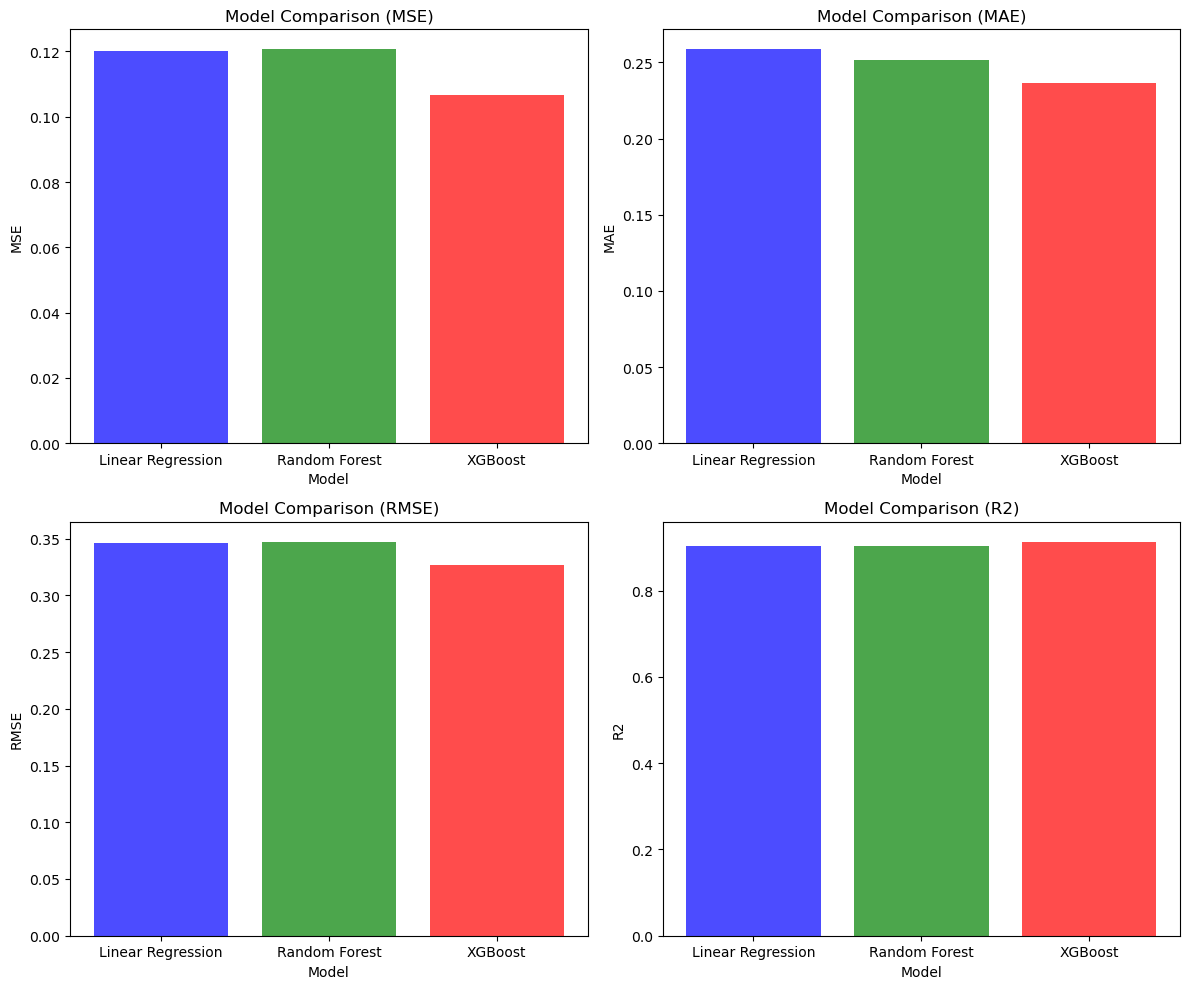

In [50]:
plot_comparison(results)

In [51]:
def display_sample_predictions(trained_models: dict, X_test: pd.DataFrame, y_test: pd.Series, n_samples: int) -> None:
    """
    This function displays the predictions of the models for a given number of samples.

    Args:
        trained_models (dict): Dictionary containing the trained models.
        X_test (pd.DataFrame): Test set features.
        y_test (pd.Series): Test set target.
        n_samples (int): Number of samples to display.

    """
    # Select random samples
    samples = random.sample(range(len(X_test)), n_samples)
    X_samples = X_test.iloc[samples]
    y_samples = y_test.iloc[samples]

    # Display predictions
    print("Sample Flights:")

    # Loop through samples
    for i, idx in enumerate(samples):
        print(f"\nSample {i + 1}:")
        print(f"Real price: {round(math.exp(y_samples.iloc[i]),0)}")

        # Loop through models
        for model_name, model in trained_models.items():
            y_pred = model.predict(X_samples.iloc[[i]])
            print(f"{model_name} predicted price: {round(math.exp(y_pred[0]),0)}")

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=423)
display_sample_predictions(trained_models, X_test, y_test, 4)

Sample Flights:

Sample 1:
Real price: 2410.0
Linear Regression predicted price: 3137.0
Random Forest predicted price: 3402.0
XGBoost predicted price: 3293.0

Sample 2:
Real price: 53440.0
Linear Regression predicted price: 53208.0
Random Forest predicted price: 57045.0
XGBoost predicted price: 56151.0

Sample 3:
Real price: 34460.0
Linear Regression predicted price: 34204.0
Random Forest predicted price: 34661.0
XGBoost predicted price: 33729.0

Sample 4:
Real price: 10317.0
Linear Regression predicted price: 6790.0
Random Forest predicted price: 5534.0
XGBoost predicted price: 5777.0
